In [24]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D 
import numpy as np
%matplotlib inline

admissions =  pd.read_csv("Downloads/ADMISSIONS.csv")
admissions['admTime'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['dischTime'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['deathTime'] = pd.to_datetime(admissions['DEATHTIME'])
admissions['losDays'] = admissions['dischTime'] - admissions['admTime']
admissions['los'] = admissions['losDays'] / np.timedelta64(1, 'D')
# @todo research Should we round it to floor or ceil??
admissions['losRound'] = np.round(admissions['losDays'] / np.timedelta64(1, 'D'))
admissions['regTime'] = pd.to_datetime(admissions['EDREGTIME'])
admissions['outTime'] = pd.to_datetime(admissions['EDOUTTIME'])
#admissions['totalTimeStay'] =  np.round((admissions['outTime'] - admissions['regTime'])/np.timedelta64(1, 'D'))
admissions['totalTimeStay'] =  np.round((admissions['outTime'] - admissions['regTime'])/np.timedelta64(1, 'h'))

Steps:
    
    1) clean organ donors : Find all patients with negative length of stay    
    
    2) Get rid of newborn admission type (reduce ? number of rows)
    
    3) DEATHTIME is only present if the patient died in-hospital, and is almost always the same as the patient’s DISCHTIME.
    
    Let's  mark which patient died in hospital and who died outside (binary)    
    
    4) Combine urgent and emergency -> Only two types of admissions left remaining


## 1) clean organ donors : Find all patients with negative length of stay

In [25]:
admissions = admissions[admissions["losRound"] > 0] #### 16 people ## 3 are newborn :(

## 2) Get rid of newborn admission type

In [26]:
admissions = admissions[admissions["ADMISSION_TYPE"] != 'NEWBORN']

## 4) Combine urgent and emergency -> Only two types of admissions left remaining


In [27]:
#replace urgent with emergency
admissions["ADMISSION_TYPE"] = admissions["ADMISSION_TYPE"].replace('URGENT', 'EMERGENCY')

In [28]:
missingCharts = admissions[admissions['HAS_CHARTEVENTS_DATA'] == 0]
missingCharts.head(5)

##Nothing unusual -- Will be getting rid of these if connecting with chartevents (1592 rows)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,admTime,dischTime,deathTime,losDays,los,losRound,regTime,outTime,totalTimeStay
69,67,67,186474,2155-02-25 12:45:00,2155-03-06 15:00:00,NaN,EMERGENCY,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,...,0,2155-02-25 12:45:00,2155-03-06 15:00:00,NaT,9 days 02:15:00,9.093750,9.0,NaT,NaT,NaN
87,85,84,120969,2196-02-02 07:15:00,2196-02-04 17:48:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,2196-02-02 07:15:00,2196-02-04 17:48:00,NaT,2 days 10:33:00,2.439583,2.0,NaT,NaT,NaN
143,182,135,199634,2174-05-17 09:00:00,2174-05-21 14:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,0,2174-05-17 09:00:00,2174-05-21 14:00:00,NaT,4 days 05:00:00,4.208333,4.0,NaT,NaT,NaN
261,409,323,192631,2115-05-17 21:06:00,2115-05-27 13:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SHORT TERM HOSPITAL,Medicare,...,0,2115-05-17 21:06:00,2115-05-27 13:30:00,NaT,9 days 16:24:00,9.683333,10.0,2115-05-17 13:40:00,2115-05-17 22:37:00,9.0
272,420,330,184134,2132-01-15 07:15:00,2132-01-17 10:30:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,0,2132-01-15 07:15:00,2132-01-17 10:30:00,NaT,2 days 03:15:00,2.135417,2.0,NaT,NaT,NaN


In [10]:
##need died data from patients table?

#admissions['diedInHospital'] = admissions["DEATHTIME"].notnull()
#admissions["DEATHTIME"].notnull()

###OOOPS, it is there already

#Write a clean csv file

#admissions.to_csv('admissions.csv')

### 5) combine categories in other variables (Ethinicyt, Religion etc)

In [29]:
def consolidateLoc(row):
    transfer = ["TRANSFER FROM HOSP/EXTRAM", "TRANSFER FROM SKILLED NUR", "TRANSFER FROM OTHER HEALT", "TRSF WITHIN THIS FACILITY"]
    #referral let's keep normal and premature separate
    if (row in transfer):
        return "TRANSFER"
    elif (row == 'HMO REFERRAL/SICK'):
        return "PHYS REFERRAL/NORMAL DELI"
    else:
        return row
    
admissions['ADMISSION_LOCATION'] = admissions.ADMISSION_LOCATION.map(consolidateLoc)

In [30]:
admissions['ADMISSION_LOCATION'].value_counts()

EMERGENCY ROOM ADMIT         22341
CLINIC REFERRAL/PREMATURE     9890
PHYS REFERRAL/NORMAL DELI     9336
TRANSFER                      8684
** INFO NOT AVAILABLE **         4
Name: ADMISSION_LOCATION, dtype: int64

In [31]:
admissions[admissions['ADMISSION_LOCATION'] == '** INFO NOT AVAILABLE **']

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,admTime,dischTime,deathTime,losDays,los,losRound,regTime,outTime,totalTimeStay
16502,16738,13647,143439,2108-12-17 01:53:00,2108-12-23 13:00:00,NaN,EMERGENCY,** INFO NOT AVAILABLE **,HOME,Private,...,1,2108-12-17 01:53:00,2108-12-23 13:00:00,NaT,6 days 11:07:00,6.463194,6.0,NaT,NaT,NaN
18431,20027,16400,103011,2131-12-29 20:55:00,2132-01-07 16:35:00,NaN,EMERGENCY,** INFO NOT AVAILABLE **,REHAB/DISTINCT PART HOSP,Medicare,...,1,2131-12-29 20:55:00,2132-01-07 16:35:00,NaT,8 days 19:40:00,8.819444,9.0,NaT,NaT,NaN
24028,25368,20778,113683,2180-12-02 17:46:00,2180-12-11 19:21:00,NaN,EMERGENCY,** INFO NOT AVAILABLE **,REHAB/DISTINCT PART HOSP,Medicare,...,1,2180-12-02 17:46:00,2180-12-11 19:21:00,NaT,9 days 01:35:00,9.065972,9.0,2180-12-02 14:10:00,2180-12-02 20:03:00,6.0
25617,23307,19082,187326,2169-10-30 04:28:00,2169-11-06 19:45:00,NaN,EMERGENCY,** INFO NOT AVAILABLE **,SNF,Medicare,...,1,2169-10-30 04:28:00,2169-11-06 19:45:00,NaT,7 days 15:17:00,7.636806,8.0,2169-10-30 02:07:00,2169-10-30 06:01:00,4.0


In [32]:
admissions = admissions[admissions['ADMISSION_LOCATION'] != '** INFO NOT AVAILABLE **']

In [33]:
#Language
admissions['LANGUAGE'][admissions.LANGUAGE != 'ENGL'] = "OTHER"

In [34]:
admissions.LANGUAGE.value_counts()

ENGL     28468
OTHER    21783
Name: LANGUAGE, dtype: int64

##@todo May be make it binary? So instead of 2 we get 1.

In [36]:
##religion

def conRel(row):
    keeping = ["CATHOLIC", "JEWISH", "PROTESTANT QUAKER"]
    
    if(row == "UNOBTAINABLE" or row == "NOT SPECIFIED"):
        return "NOT SPECIFIED"
    elif(row not in keeping ):
        return "OTHER"
    
admissions['RELIGION'] = admissions.RELIGION.map(conRel)

In [38]:
admissions.RELIGION.value_counts()

NOT SPECIFIED    15501
OTHER             5145
Name: RELIGION, dtype: int64

## 6) Linear Models

In [7]:
import statsmodels.formula.api as sm

In [9]:
#lmDeath = sm.ols(formula="diedInHospital ~ los", data=admissions).fit()

In [ ]:
print lmDeath.params



In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(admissions[['los']], admissions['diedInHospital'])

In [ ]:
print reg.coef_

Let's keep the columns that matter

In [39]:
admissions.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,admTime,dischTime,deathTime,losDays,los,losRound,regTime,outTime,totalTimeStay
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,1,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,1 days 03:28:00,1.144444,1.0,2196-04-09 10:06:00,2196-04-09 13:24:00,3.0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,5 days 11:55:00,5.496528,5.0,NaT,NaT,NaN


In [45]:
## No need of rowID, 
adm_nums = admissions[['los', 'totalTimeStay']]
adm_nums.corr()

,los,totalTimeStay
los,1.000000,0.025062
totalTimeStay,0.025062,1.000000


#### Finding : no correlation for los and totalTimeStay

In [47]:
#admissions.corr()

### PIVOT Tables and more EDA

Create Correlation matrices/heatmap about LOS and other attributes




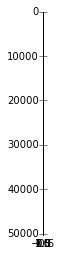

### Machine Learning

Create cohorts of patients that tend to stay longer in hospitals, or tend to get readmitted

Create cohorts of diagnoses, medications, procedures etc that lead to same results